In [2]:
import os
import sys
import json
import torch
import argparse
import numpy as np
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from random import randint

sys.path.append(os.path.abspath('../'))
from Agent import MLPNetwork

/home/vateseifelfrej/anaconda3/envs/maddpg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# training params

alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# number of tokens in alphabet                    
n_tokens = len(alphabet)

# dimension of goal id (RGB color of landmarks)
n_goal_id = 3

num_agents = 2
num_landmarks = 10

# I/O of speaker and listener
speaker_in = n_goal_id
speaker_out = n_tokens
listener_in = 2 + 2*num_landmarks + n_tokens
listener_out = 2

# landamrk colors
landmarks_c = sns.color_palette(n_colors=num_landmarks)
landmarks_c = torch.tensor(landmarks_c).unsqueeze(1)

In [311]:
speaker = MLPNetwork(speaker_in, speaker_out)

listener = MLPNetwork(listener_in, listener_out)


optimizer_s = torch.optim.Adam(list(speaker.parameters()),  lr=1e-4)
optimizer_l = torch.optim.Adam(list(listener.parameters()), lr=1e-3)

In [312]:
loss_history = []
mse = nn.MSELoss()
nlloss = nn.NLLLoss()

iterations = 200
epochs = 100
batch_size = 64

for it in tqdm(range(iterations)):
  for i in range(epochs):
    # landmarks positions
    landmarks_p = ((torch.rand((batch_size, 2*num_landmarks)) - 0.5) * 2)
    landmarks_xy = landmarks_p.reshape(batch_size, num_landmarks, 2)

    vel = torch.rand((batch_size, 2))
    # sample target landmark indices
    ids = torch.randint(num_landmarks, (batch_size,))
    # speaker input
    goal_landmarks = (landmarks_c.repeat(batch_size, 1, 1)[ids]).squeeze(1)
    # pass through observer
    msg = F.gumbel_softmax(speaker(goal_landmarks), hard=True)
    # listener observation
    obs = torch.cat((vel, landmarks_p, msg), 1)  
    action = listener(obs)
    target = landmarks_xy[torch.arange(batch_size), ids]


    if it%2==0:
      optimizer_s.zero_grad()
    else:
      optimizer_l.zero_grad()
      
    loss = mse(action, target)
    loss.backward()
    if it%2==0:
      optimizer_s.step()
    else:
      optimizer_l.step()

    if (it*epochs+i)%100==0:
      loss_history.append(loss.item())

100%|██████████| 200/200 [00:28<00:00,  6.91it/s]


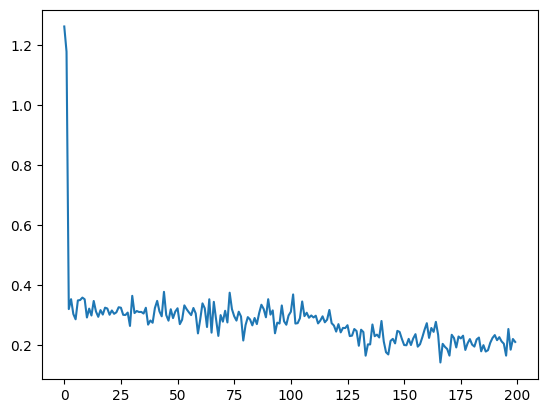

In [313]:
plt.plot(loss_history)

In [344]:
for i in range(num_landmarks):
  msg = F.gumbel_softmax(speaker(landmarks_c[i]), hard=True)
  print(alphabet[msg.argmax()], i)

X 0
D 1
V 2
D 3
P 4
D 5
P 6
P 7
D 8
X 9


In [345]:
# letters used for which landmark color by speaker
msgLandmarkMap = {i: [] for  i in range(len(alphabet))}
for i in range(num_landmarks):
  msg = F.gumbel_softmax(speaker(landmarks_c[i]), hard=False)
  li = msg[0].argmax().item()
  msgLandmarkMap[li].append(i)



In [346]:
# landmarks positions
batch_size = 1
landmarks_p = ((torch.rand((batch_size, 2*num_landmarks)) - 0.5) * 2)
landmarks_xy = landmarks_p.reshape(batch_size, num_landmarks, 2)
def computeCentroid(msg):
  """Given a message (the argmax) it checks which other landmarks use the same msg and computes the centroid and the mean color"""
  xy = torch.mean(landmarks_xy[:,msgLandmarkMap[msg]], dim=1)
  c = torch.mean(landmarks_c[msgLandmarkMap[msg]], dim=0)
  return xy, c

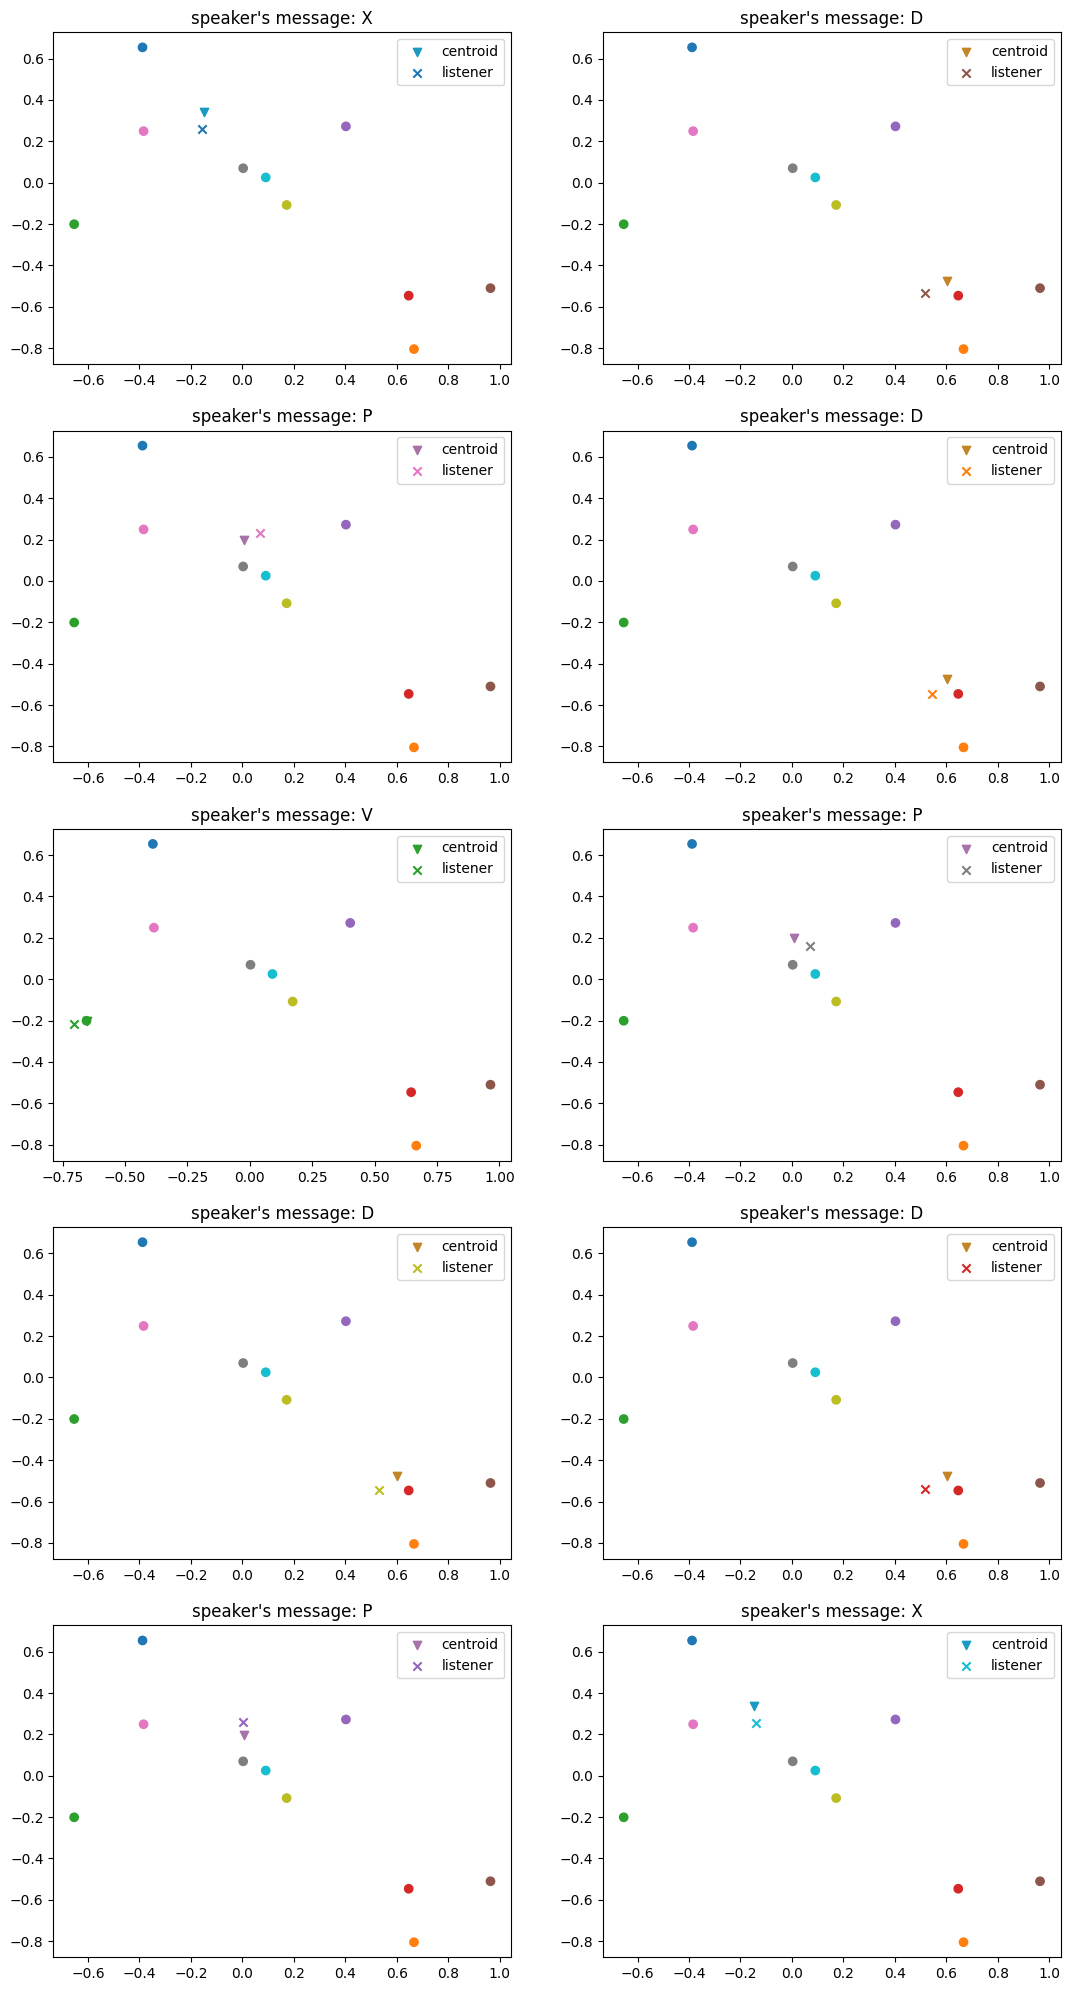

In [347]:
fig, ax = plt.subplots(nrows=int(num_landmarks/2), ncols=2, figsize=(13, 25))


for ix in range(num_landmarks):
  
  vel = torch.rand((batch_size, 2))
  # sample target landmark
  #ix = randint(0, num_landmarks-1)
  # pass through observer
  msg = F.gumbel_softmax(speaker(landmarks_c[ix].repeat(batch_size, 1)), hard=False)
  # goal id (kinda useless to have it)
  goal_id = torch.cat(list(landmarks_c[randint(0, num_landmarks-1)] for _ in range(batch_size)), 0)
  # listener observation
  obs = torch.cat((vel, landmarks_p, msg), 1)  
  # predict landmark pos
  action = listener(obs)
  # compute centroid of chosen message
  centroid_xy, centroid_c = computeCentroid(msg[0].argmax().item())


  #plt.figure()
  ax[ix%int(num_landmarks/2)][ix%2].scatter([l for i, l in enumerate(landmarks_p[0]) if i%2==0], [l for i, l in enumerate(landmarks_p[0]) if i%2==1], marker='o', c=landmarks_c.squeeze())
  ax[ix%int(num_landmarks/2)][ix%2].scatter(centroid_xy[0, 0], centroid_xy[0, 1], marker='v', c=centroid_c, label='centroid')
  ax[ix%int(num_landmarks/2)][ix%2].scatter(action[0,0].detach().numpy(), action[0,1].detach().numpy(), marker='x', c=landmarks_c[ix], label='listener')
  ax[ix%int(num_landmarks/2)][ix%2].legend(loc='best')
  ax[ix%int(num_landmarks/2)][ix%2].set_title(f"speaker's message: {alphabet[msg[0].argmax()]}")

#fig.savefig('speaker_listener_centroid.png')